## Different ways to build Keras models

### The Sequential model
The simplest way to build a Keras model is to use the Sequential model, which you already know about.


add layers incrementally via the add() method

In [1]:
from tensorflow import keras 
from tensorflow.keras import layers
  
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(10, activation="softmax")
])

In [2]:
model = keras.Sequential()
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(10, activation="softmax"))

In [3]:
model.weights

ValueError: Weights for model sequential_1 have not yet been created. Weights are created when the Model is first called on inputs or `build()` is called with an `input_shape`.

In [4]:
model.build(input_shape=(None, 3))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 64)                256       
                                                                 
 dense_3 (Dense)             (None, 10)                650       
                                                                 
Total params: 906
Trainable params: 906
Non-trainable params: 0
_________________________________________________________________


In [5]:
model = keras.Sequential()
model.add(keras.Input(shape=(3,)))
model.add(layers.Dense(64, activation="relu"))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 64)                256       
                                                                 
Total params: 256
Trainable params: 256
Non-trainable params: 0
_________________________________________________________________


### Functional API

In [6]:
inputs = keras.Input(shape=(3,), name="my_input")
features = layers.Dense(64, activation="relu")(inputs)
outputs = layers.Dense(10, activation="softmax")(features)
model = keras.Model(inputs=inputs, outputs=outputs)

In [7]:
vocabulary_size = 10000 
num_tags = 100 
num_departments = 4 
  
title = keras.Input(shape=(vocabulary_size,), name="title")
text_body = keras.Input(shape=(vocabulary_size,), name="text_body")
tags = keras.Input(shape=(num_tags,), name="tags")
 
features = layers.Concatenate()([title, text_body, tags])
features = layers.Dense(64, activation="relu")(features)
 
priority = layers.Dense(1, activation="sigmoid", name="priority")(features)
department = layers.Dense(
    num_departments, activation="softmax", name="department")(features)
 
model = keras.Model(inputs=[title, text_body, tags],
                    outputs=[priority, department])

In [8]:
import numpy as np
  
num_samples = 1280 
  
title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples, num_tags))
 
priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))
 
model.compile(optimizer="rmsprop",
              loss=["mean_squared_error", "categorical_crossentropy"],
              metrics=[["mean_absolute_error"], ["accuracy"]])
model.fit([title_data, text_body_data, tags_data],
          [priority_data, department_data],
          epochs=1)
model.evaluate([title_data, text_body_data, tags_data],
               [priority_data, department_data])
priority_preds, department_preds = model.predict(
    [title_data, text_body_data, tags_data])

40/40 [==============================] - 0s 3ms/step


In [12]:
keras.utils.plot_model(model, "ticket_classifier.png")

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [13]:
model.layers

In [14]:
model.layers[3].input


[<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>,
 <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'text_body')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'tags')>]

In [15]:
model.layers[3].output

<KerasTensor: shape=(None, 20100) dtype=float32 (created by layer 'concatenate')>

In [16]:
features = model.layers[4].output
difficulty = layers.Dense(3, activation="softmax", name="difficulty")(features)
  
new_model = keras.Model(
    inputs=[title, text_body, tags],
    outputs=[priority, department, difficulty])

### Subclassing the Model class
In the __init__() method, define the layers the model will use.

In the call() method, define the forward pass of the model, 

In [17]:
class CustomerTicketModel(keras.Model):
  
    def __init__(self, num_departments):
        super().__init__()
        self.concat_layer = layers.Concatenate()
        self.mixing_layer = layers.Dense(64, activation="relu")
        self.priority_scorer = layers.Dense(1, activation="sigmoid")
        self.department_classifier = layers.Dense(
            num_departments, activation="softmax")
 
    def call(self, inputs):
        title = inputs["title"]
        text_body = inputs["text_body"]
        tags = inputs["tags"]
  
        features = self.concat_layer([title, text_body, tags])
        features = self.mixing_layer(features)
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        return priority, department

###  Using built-in training and evaluation loops

classic: 

In [18]:
from tensorflow.keras.datasets import mnist
  
def get_mnist_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation="relu")(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation="softmax")(features)
    model = keras.Model(inputs, outputs)
    return model
  
(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255 
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255 
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]
  
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)

Epoch 1/3
1563/1563 [==============================] - 5s 3ms/step - loss: 0.2967 - accuracy: 0.9123 - val_loss: 0.1507 - val_accuracy: 0.9569
Epoch 2/3
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1615 - accuracy: 0.9530 - val_loss: 0.1103 - val_accuracy: 0.9689
Epoch 3/3
313/313 [==============================] - 0s 837us/step


A Keras metric is a subclass of the keras.metrics.Metric class. Like layers, a metric has an internal state stored in TensorFlow variables. Unlike layers, these variables aren’t updated via backpropagation, so you have to write the state-update logic yourself, which happens in the update_state() method.

In [20]:
import tensorflow as tf
  
class RootMeanSquaredError(keras.metrics.Metric):
 
    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        self.total_samples = self.add_weight(
            name="total_samples", initializer="zeros", dtype="int32")
 
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)
    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))
    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

In [21]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", RootMeanSquaredError()])
model.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 [==============================] - 6s 3ms/step - loss: 0.2967 - accuracy: 0.9114 - rmse: 7.1753 - val_loss: 0.1524 - val_accuracy: 0.9557 - val_rmse: 7.3531
Epoch 2/3
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1581 - accuracy: 0.9539 - rmse: 7.3491 - val_loss: 0.1191 - val_accuracy: 0.9682 - val_rmse: 7.4059
Epoch 3/3
313/313 [==============================] - 0s 1ms/step - loss: 0.0910 - accuracy: 0.9747 - rmse: 7.4330


### The EarlyStopping callback 
interrupts training once a target metric being monitored has stopped improving for a fixed number of epochs. 

In [22]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor="val_accuracy",
        patience=2,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath="checkpoint_path.keras",
        monitor="val_loss",
        save_best_only=True,
    )
]
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          callbacks=callbacks_list,
          validation_data=(val_images, val_labels))

Epoch 1/10
1563/1563 [==============================] - 6s 3ms/step - loss: 0.2967 - accuracy: 0.9103 - val_loss: 0.1499 - val_accuracy: 0.9583
Epoch 2/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1617 - accuracy: 0.9531 - val_loss: 0.1139 - val_accuracy: 0.9679
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1285 - accuracy: 0.9639 - val_loss: 0.1129 - val_accuracy: 0.9711
Epoch 4/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1146 - accuracy: 0.9675 - val_loss: 0.1019 - val_accuracy: 0.9744
Epoch 5/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1030 - accuracy: 0.9714 - val_loss: 0.0983 - val_accuracy: 0.9739
Epoch 6/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0954 - accuracy: 0.9747 - val_loss: 0.0954 - val_accuracy: 0.9771
Epoch 7/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0877 - accuracy: 0.9756 - val_loss: 0.0889 - val_accuracy:

### Writing your own callbacks

In [24]:
from matplotlib import pyplot as plt
  
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []
  
    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))
  
    def on_epoch_end(self, epoch, logs):
        plt.clf()
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses,
                 label="Training loss for each batch")
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"plot_at_epoch_{epoch}")
        self.per_batch_losses = []

Epoch 1/10
1563/1563 [==============================] - 6s 3ms/step - loss: 0.2953 - accuracy: 0.9105 - val_loss: 0.1499 - val_accuracy: 0.9570
Epoch 2/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1610 - accuracy: 0.9534 - val_loss: 0.1155 - val_accuracy: 0.9683
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.1336 - accuracy: 0.9622 - val_loss: 0.1041 - val_accuracy: 0.9708
Epoch 4/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1140 - accuracy: 0.9688 - val_loss: 0.0969 - val_accuracy: 0.9750
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.1044 - accuracy: 0.9708 - val_loss: 0.1007 - val_accuracy: 0.9740
Epoch 6/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0953 - accuracy: 0.9733 - val_loss: 0.0934 - val_accuracy: 0.9762
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0905 - accuracy: 0.9747 - val_loss: 0.0906 - val_accuracy:

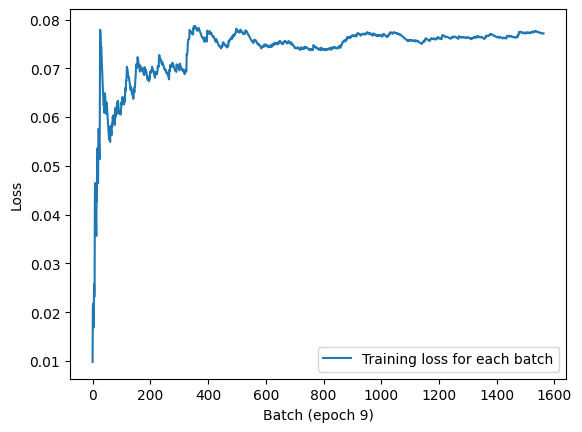

In [25]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
model.fit(train_images, train_labels,
          epochs=10,
          callbacks=[LossHistory()],
          validation_data=(val_images, val_labels))

### TensorBoard
to get information about how well a model performs—as much information as possible

In [28]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])
  
tensorboard = keras.callbacks.TensorBoard(
    log_dir="/path",
)
model.fit(train_images, train_labels,
          epochs=10,
          validation_data=(val_images, val_labels),
          callbacks=[tensorboard])

Epoch 1/10
1563/1563 [==============================] - 6s 3ms/step - loss: 0.2945 - accuracy: 0.9131 - val_loss: 0.1435 - val_accuracy: 0.9583
Epoch 2/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1604 - accuracy: 0.9542 - val_loss: 0.1142 - val_accuracy: 0.9688
Epoch 3/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1319 - accuracy: 0.9636 - val_loss: 0.1070 - val_accuracy: 0.9715
Epoch 4/10
1563/1563 [==============================] - 5s 4ms/step - loss: 0.1149 - accuracy: 0.9678 - val_loss: 0.0991 - val_accuracy: 0.9731
Epoch 5/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.1047 - accuracy: 0.9710 - val_loss: 0.0939 - val_accuracy: 0.9755
Epoch 6/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0947 - accuracy: 0.9737 - val_loss: 0.0893 - val_accuracy: 0.9768
Epoch 7/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0886 - accuracy: 0.9757 - val_loss: 0.0950 - val_accuracy:

In [29]:
metric = keras.metrics.SparseCategoricalAccuracy()
targets = [0, 1, 2]
predictions = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
metric.update_state(targets, predictions)
current_result = metric.result()
print(f"result: {current_result:.2f}")

result: 1.00


In [30]:
model = get_mnist_model()
 
loss_fn = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.RMSprop()
metrics = [keras.metrics.SparseCategoricalAccuracy()]
loss_tracking_metric = keras.metrics.Mean()
 
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(targets, predictions)
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))
 
    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs[metric.name] = metric.result()
 
    loss_tracking_metric.update_state(loss)
    logs["loss"] = loss_tracking_metric.result()
    return logs

In [31]:
def reset_metrics():
    for metric in metrics:
        metric.reset_state()
    loss_tracking_metric.reset_state()

In [32]:
training_dataset = tf.data.Dataset.from_tensor_slices(
    (train_images, train_labels))
training_dataset = training_dataset.batch(32)
epochs = 3 
for epoch in range(epochs):
    reset_metrics()
    for inputs_batch, targets_batch in training_dataset:
        logs = train_step(inputs_batch, targets_batch)
    print(f"Results at the end of epoch {epoch}")
    for key, value in logs.items():
        print(f"...{key}: {value:.4f}")

Results at the end of epoch 0
...sparse_categorical_accuracy: 0.9140
...loss: 0.2889
Results at the end of epoch 1
...sparse_categorical_accuracy: 0.9539
...loss: 0.1611
Results at the end of epoch 2
...sparse_categorical_accuracy: 0.9633
...loss: 0.1331


In [33]:
def test_step(inputs, targets):
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)
  
    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs["val_" + metric.name] = metric.result()
    loss_tracking_metric.update_state(loss)
    logs["val_loss"] = loss_tracking_metric.result()
    return logs
  
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics() 
for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch, targets_batch) 
print("Evaluation results:") 
for key, value in logs.items(): 
    print(f"...{key}: {value:.4f}")

Evaluation results:
...val_sparse_categorical_accuracy: 0.9677
...val_loss: 0.1140


It’s more performant to compile your TensorFlow code into a computation graph that can be globally optimized in a way that code interpreted line by line cannot

In [34]:
@tf.function
def test_step(inputs, targets):
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)
  
    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs["val_" + metric.name] = metric.result()
  
    loss_tracking_metric.update_state(loss)
    logs["val_loss"] = loss_tracking_metric.result()
    return logs
  
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics() 
for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch, targets_batch) 
print("Evaluation results:") 
for key, value in logs.items():
    print(f"...{key}: {value:.4f}")

Evaluation results:
...val_sparse_categorical_accuracy: 0.9677
...val_loss: 0.1140


#### Leveraging fit() with a custom training loop